In [1]:
import sys
import math
import ROOT
from ROOT import kBlack,kWhite,kGray,kRed,kPink,kMagenta,kViolet,kBlue,kAzure,kCyan,kTeal,kGreen,kSpring,kYellow,kOrange,kDashed,kSolid,kDotted
from ROOT import gSystem, gROOT, TCanvas, TGraphErrors, TMultiGraph, TF1, gStyle, kRed, kBlue, kGray, TFile, TTree, TPad, gPad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psyplot.project as psy
import seaborn as sns
print("Python version")
print (sys.version)
import uproot

# Setting up the ATLAS style
ROOT.gROOT.LoadMacro("/Users/jordi/code/AtlasStyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/Users/jordi/code/AtlasStyle/AtlasUtils.C")
ROOT.SetAtlasStyle()

def prepare_graph(graph, name, title, colour = 9, markerStyle = 21, factor = 1):
   # graph settings
   graph.SetTitle(title)
   graph.SetName(name)
   graph.SetMarkerStyle(markerStyle)
   graph.SetMarkerSize(1.4)
   graph.SetMarkerColor(colour)
   graph.SetLineColor(colour)
   # set Y axis
   graph.GetYaxis().SetTitleSize(0.06)
   graph.GetYaxis().SetTitleOffset(1.1)
   graph.GetYaxis().SetLabelSize(0.045)
   graph.GetYaxis().SetNdivisions(504)
   # set X axis
   graph.GetXaxis().SetTitleSize(0.07)
   graph.GetXaxis().SetTitleOffset(1.)
   graph.GetXaxis().SetLabelSize(0.05)
   graph.GetYaxis().SetNdivisions(506)



Welcome to JupyROOT 6.26/06
Python version
3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:13) [Clang 14.0.6 ]

Applying ATLAS style settings...



In [2]:
qToGeV = (6250 * 3.6) / (1.e9)
threshold = 1 # threshold on the pixels in fC
upperThreshold = 64 # upper threshold on the pidxels in fC
#files = ["1GeV_"+particle,"10GeV_"+particle,"100GeV_"+particle,"500GeV_"+particle,"1000GeV_"+particle]
energies = ['1','10','50','100','250','500','1000']
files_tmp = []
nFiles = 10
files = []
for ie in energies:    
    files_tmp = []
    for i in range(nFiles):
        files_tmp.append(ie+"GeV_preshowerUpgrade_calo_1000events_"+str(i+1))
    files.append(files_tmp)
file_shape = np.shape(files)
print('file shape ',file_shape)
# create an empty 2D list. We are going to store the pandas dataframes here
pds = np.empty(shape=file_shape+(0,)).tolist()
#for ifile, filename in enumerate(files):
for x in range(len(files)):
    for y in range(len(files[x])):
        print('Opening '+files[x][y],end=' \n')
        energy = int(files[x][y].split('GeV')[0])
        #print('energy '+str(energy)+' GeV')
        path = "/Users/jordi/code/samples/resolution/geant4/"
        fileName = path+files[x][y]+".root"
        ufile = uproot.open(fileName)
        treeName = "hits"
        tree = ufile[treeName]
        event = tree.arrays(["event","QfC","x","y","z","Edep_Sci_calo","siliconHits_ID"], library="pd",entry_stop=-1)
        #pixels = event.groupby(['siliconHits_ID','event','x','y','Edep_Sci_calo'],as_index=False)['QfC'].sum()
        # check if there are two particles (hits) in the same pixel
        duplicate_rows = event[event.duplicated(['x','y','z','event'], keep=False)]
        duplicate_rows = duplicate_rows.sort_values('x')
        if not duplicate_rows.empty:
            print("Found hits with same x,y,z!")
        # add all charges corresponding to a given pixel for a given event
        pixels=event.groupby(['event','x','y','z','Edep_Sci_calo']).agg({'QfC':'sum'})
        # filter the events to have pixel charge > 1 fC
        pixels_1fC = pixels[pixels['QfC'] > threshold]
        pixels_1fC = pixels_1fC[pixels_1fC['QfC'] < upperThreshold]
        #print(pixels_1fC)
        # as_index = false keeps the name of the summed column (in this case QfC)
        pixels_1fC = pixels_1fC.groupby(['event','Edep_Sci_calo'])['QfC'].sum().reset_index(name ='QfC')
        #print(pixels_1fC.head())
        # convert all charges in fC to energy in GeV
        pixels_1fC.loc[:,'QfC'] *= qToGeV
        #print('filling ',[x],[y])
        pds[x][y] = pixels_1fC
        
    

file shape  (7, 10)
Opening 1GeV_preshowerUpgrade_calo_1000events_1 
Opening 1GeV_preshowerUpgrade_calo_1000events_2 
Opening 1GeV_preshowerUpgrade_calo_1000events_3 
Opening 1GeV_preshowerUpgrade_calo_1000events_4 
Opening 1GeV_preshowerUpgrade_calo_1000events_5 
Opening 1GeV_preshowerUpgrade_calo_1000events_6 
Opening 1GeV_preshowerUpgrade_calo_1000events_7 
Opening 1GeV_preshowerUpgrade_calo_1000events_8 
Opening 1GeV_preshowerUpgrade_calo_1000events_9 
Opening 1GeV_preshowerUpgrade_calo_1000events_10 
Opening 10GeV_preshowerUpgrade_calo_1000events_1 
Opening 10GeV_preshowerUpgrade_calo_1000events_2 
Opening 10GeV_preshowerUpgrade_calo_1000events_3 
Opening 10GeV_preshowerUpgrade_calo_1000events_4 
Opening 10GeV_preshowerUpgrade_calo_1000events_5 
Opening 10GeV_preshowerUpgrade_calo_1000events_6 
Opening 10GeV_preshowerUpgrade_calo_1000events_7 
Opening 10GeV_preshowerUpgrade_calo_1000events_8 
Opening 10GeV_preshowerUpgrade_calo_1000events_9 
Opening 10GeV_preshowerUpgrade_calo_100

In [3]:
import pandas as pd
# now we are going to concatenate all the panda dataframes corresponding to the same energy and put them in a list
pixels_1fC = []
for x in range(len(files)):
    pixels_1fC_tmp = pd.DataFrame()
    for y in range(len(files[x])):
        pixels_1fC_tmp = pd.concat([pixels_1fC_tmp,pds[x][y]])
    pixels_1fC.append(pixels_1fC_tmp)
print(np.shape(pixels_1fC))


(7,)


/opt/homebrew/Caskroom/miniforge/base/envs/env_root_root6.26.06/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [4]:
# plot the energy in the calorimeter after the linear correction from the preshower
import hist
file = uproot.recreate("resolution_"+str(threshold)+"fC.root")
histos = []
xmin = []
xmax = []
for i in range(len(pixels_1fC)):
    QfC = pixels_1fC[i]['QfC'].to_numpy()
    Edep_Sci_calo = pixels_1fC[i]['Edep_Sci_calo'].to_numpy()
    # different charge thresholds have different slope means
    if threshold == 1:
        slope = 253.54813886247544
    if threshold == 0.5:
        slope = 166.501526259635
    QfC = QfC*slope
    x = np.add(QfC,Edep_Sci_calo)
    if (int(energies[i]) == 1000):
        xmin.append(145.)
        xmax.append(170.)
    else:
        xmin.append(x.min())
        xmax.append(x.max())
    bins = 100
    print(QfC)
    print(xmin,xmax)
    hist1d = hist.Hist(hist.axis.Regular(bins, xmin[i], xmax[i]), name='E [GeV]')
    hist1d_no_corr = hist.Hist(hist.axis.Regular(bins, xmin[i], xmax[i]), name='E [GeV]') # histogram without the preshower correction
    hist1d.fill(x)
    hist1d_no_corr.fill(Edep_Sci_calo)
    outName = "hist_1d_"+energies[i]+"GeV"
    outName_no_corr = "hist_1d_"+energies[i]+"GeV_no_corr"
    file[outName] = hist1d
    file[outName_no_corr] = hist1d_no_corr
    histos.append(outName)

[0.13494669 0.05291996 0.21801102 ... 0.12542787 0.09745345 0.18833488]
[0.016256835357505453] [0.4729961207799098]
[0.80051751 0.64018523 0.74515399 ... 0.79787552 0.62081463 0.75110056]
[0.016256835357505453, 0.9090009944899644] [0.4729961207799098, 2.1577831886757726]
[1.08242664 2.09043751 2.487835   ... 2.85801516 2.28257673 3.22846544]
[0.016256835357505453, 0.9090009944899644, 3.6292776170446426] [0.4729961207799098, 2.1577831886757726, 8.917740433495169]
[1.59070256 4.47302779 5.27831299 ... 3.09039174 3.89349869 2.28480782]
[0.016256835357505453, 0.9090009944899644, 3.6292776170446426, 11.779832260713162] [0.4729961207799098, 2.1577831886757726, 8.917740433495169, 17.177033707881147]
[6.1199796  9.3695829  4.69533832 ... 8.26484556 8.4533482  4.16403883]
[0.016256835357505453, 0.9090009944899644, 3.6292776170446426, 11.779832260713162, 30.04309985282209] [0.4729961207799098, 2.1577831886757726, 8.917740433495169, 17.177033707881147, 42.63309873448205]
[ 9.3968092  15.99258006 

In [5]:
# open the file with all the deposited energy distributions
f = ROOT.TFile("resolution_"+str(threshold)+"fC.root","READ")
gReso = TGraphErrors()
gMean = TGraphErrors()
gSigma = TGraphErrors()
print(f.ls())
for ihisto, histoname in enumerate(histos):
    h_reso = f.Get("hist_1d_"+energies[ihisto]+"GeV")
    c_reso = ROOT.TCanvas("c_reso", "", 700, 600)
    c_reso.cd()
    h_reso.Draw('')
    # define the fits
    # we are going to use a gaussian fit first to guess the parameters from the crystal ball fit
    preFitReso = TF1("cb", "crystalball",xmin[ihisto],xmax[ihisto])
    preFitReso_gaus = TF1("preGaus", "gaus",xmin[ihisto],xmax[ihisto])
    resultPre_gaus = h_reso.Fit(preFitReso_gaus, "SQRN")
    finalGaus_xmin = resultPre_gaus.Get().Parameter(1) - 2. * resultPre_gaus.Get().Parameter(2)
    finalGaus_xmax = resultPre_gaus.Get().Parameter(1) + 2. * resultPre_gaus.Get().Parameter(2)
    fitReso_gaus = TF1("finalGaus", "gaus", finalGaus_xmin, finalGaus_xmax)
    # fit gaussian
    result_gaus = h_reso.Fit(fitReso_gaus, "SQR")
    # get parameters from the gaussian
    mean = result_gaus.Get().Parameter(1)
    dmean = result_gaus.Get().Error(1)
    sigma = result_gaus.Get().Parameter(2)
    dsigma = result_gaus.Get().Error(2)
    resolution = sigma/mean
    resolutionErrorSigma = dsigma / mean
    resolutionErrorMean = dmean * sigma / ( mean ** 2)
    resolutionError = math.sqrt( resolutionErrorSigma ** 2 +  resolutionErrorMean ** 2 )

    # define initial parameters for the crystall ball function
    cbPreConstant = 500 # controls the height of the distribution
    cbPreMean = mean
    cbPreSigma = sigma
    cbPreAlpha = -1 # controls the slope from x=0 to x = xMean
    cbPreN = 1 # controls the value of y at x = 0, the lower N is, the higher the y value
    #if int(energies[ihisto]) == 1000:
        
    # crystal ball function fit
    preFitReso.SetParameters(cbPreConstant, cbPreMean, cbPreSigma, cbPreAlpha, cbPreN)
    preFitReso.SetLineColor(kAzure)
    # get parameters from the fit
    resultPreFitReso = h_reso.Fit(preFitReso, "SREM")
    cbMean = resultPreFitReso.Get().Parameter(1)
    cbSigma = resultPreFitReso.Get().Parameter(2)
    cbdMean = resultPreFitReso.Get().Error(1)
    cbdSigma = resultPreFitReso.Get().Error(2)
    cbResolutionErrorMean = cbdMean * cbSigma / (cbMean**2)
    cbResolutionErrorSigma = cbdSigma/cbSigma
    cbResolution = cbSigma/cbMean
    cbResolutionError = math.sqrt(cbResolutionErrorSigma ** 2 + cbResolutionErrorMean ** 2)
    # plot the gaussian fit
    fitReso_gaus.Draw("same")
    print(ihisto, int(energies[ihisto]), cbResolution)
    gReso.SetPoint(ihisto, int(energies[ihisto]), cbResolution)
    gReso.SetPointError(ihisto, 0, cbResolutionError)
    gMean.SetPoint(ihisto, int(energies[ihisto]), cbMean)
    gMean.SetPointError(ihisto, 0, cbdMean)
    # Sigma graph
    gSigma.SetPoint(ihisto, int(energies[ihisto]), cbSigma)
    gSigma.SetPointError(ihisto, 0, cbdSigma)
    c_reso.SaveAs("plots/h_reso_"+energies[ihisto]+"_"+str(threshold)+"fC.pdf")
    c_reso.Close()

c_energyReso = ROOT.TCanvas("c_energyReso", "", 700, 600)
c_energyReso.cd()
gPad.SetLogx()
gReso.Print()
prepare_graph(gReso, "resolution", ";E_{beam} [GeV];#sigma_{E}/<E>", kRed+1, 21)
prepare_graph(gMean, "mean", ";E_{beam} [GeV];Mean", kRed+1, 21)
prepare_graph(gSigma, "sigma", ";E_{beam} [GeV];Sigma", kRed+1, 21)
gReso.Draw("ape")
c_energyReso.SaveAs("plots/h_reso_"+str(threshold)+"fC.pdf")
c_energyReso.Close()

# save the plots in a file
plots = TFile("energy_resolution_plots_preshowerUpgrade_calo_"+str(threshold)+"fC.root","RECREATE")
gReso.Write()
gMean.Write()
gSigma.Write()
plots.Write()
plots.Close()

None
0 1 0.2812929813293867
1 10 0.0898093931480089
2 50 0.034736473442856595
3 100 0.02276857395055756
4 250 0.012143392967323644
5 500 0.007611316533808096
6 1000 0.005529266603038821
TFile**		resolution_1fC.root	
 TFile*		resolution_1fC.root	
  KEY: TH1D	hist_1d_1GeV;1	E [GeV]
  KEY: TH1D	hist_1d_1GeV_no_corr;1	E [GeV]
  KEY: TH1D	hist_1d_10GeV;1	E [GeV]
  KEY: TH1D	hist_1d_10GeV_no_corr;1	E [GeV]
  KEY: TH1D	hist_1d_50GeV;1	E [GeV]
  KEY: TH1D	hist_1d_50GeV_no_corr;1	E [GeV]
  KEY: TH1D	hist_1d_100GeV;1	E [GeV]
  KEY: TH1D	hist_1d_100GeV_no_corr;1	E [GeV]
  KEY: TH1D	hist_1d_250GeV;1	E [GeV]
  KEY: TH1D	hist_1d_250GeV_no_corr;1	E [GeV]
  KEY: TH1D	hist_1d_500GeV;1	E [GeV]
  KEY: TH1D	hist_1d_500GeV_no_corr;1	E [GeV]
  KEY: TH1D	hist_1d_1000GeV;1	E [GeV]
  KEY: TH1D	hist_1d_1000GeV_no_corr;1	E [GeV]
 FCN=348.581 FROM MINOS     STATUS=FAILURE       332 CALLS        1439 TOTAL
                     EDM=3.23001e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER              

Info in <TCanvas::Print>: pdf file plots/h_reso_1_1fC.pdf has been created
Info in <TCanvas::Print>: pdf file plots/h_reso_10_1fC.pdf has been created
Info in <TCanvas::Print>: pdf file plots/h_reso_50_1fC.pdf has been created
Info in <TCanvas::Print>: pdf file plots/h_reso_100_1fC.pdf has been created
Info in <TCanvas::Print>: pdf file plots/h_reso_250_1fC.pdf has been created
Info in <TCanvas::Print>: pdf file plots/h_reso_500_1fC.pdf has been created
Info in <TCanvas::Print>: pdf file plots/h_reso_1000_1fC.pdf has been created
Info in <TCanvas::Print>: pdf file plots/h_reso_1fC.pdf has been created


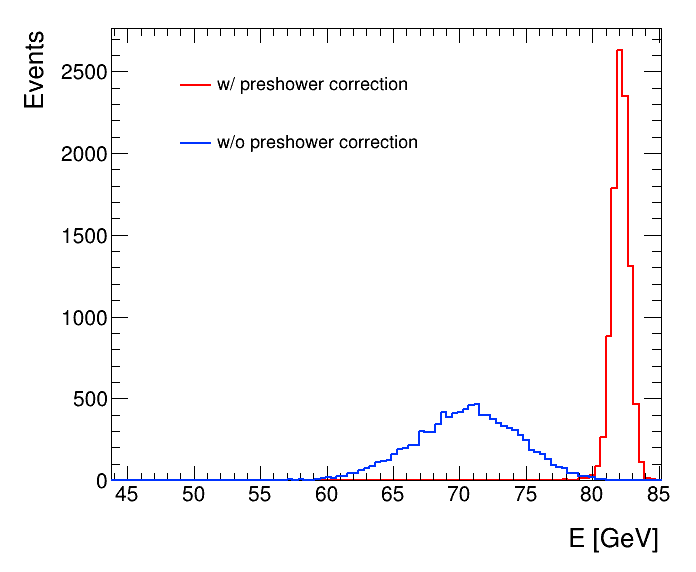

In [6]:
# For illustration purposes, let's draw one of the distributions with and without preshower correction
def prepare_th1(th1,titlex, titley, color):
   th1.GetXaxis().SetTitleOffset(1.3)
   th1.GetXaxis().SetLabelSize(0.04)
   th1.GetYaxis().SetLabelSize(0.04)
   th1.GetXaxis().SetTitle(titlex)
   th1.GetYaxis().SetTitle(titley)
   th1.SetLineColor(color)

h_reso = f.Get("hist_1d_500GeV")
h_reso_no_corr = f.Get("hist_1d_500GeV_no_corr")
prepare_th1(h_reso, "E [GeV]", "Events",kRed)
prepare_th1(h_reso_no_corr, "E [GeV]", "Events",kAzure)
c_E = ROOT.TCanvas("c_E", "", 700, 600)
c_E.cd()
gStyle.SetOptFit(0000)
h_reso.Draw("HIST")
h_reso_no_corr.Draw("sameHIST")
leg =  ROOT.TLegend(0.25,0.7,0.5,0.90)
leg.SetFillStyle(0)
leg.SetFillColor(0)
leg.SetBorderSize(0)
leg.SetTextFont(42)
leg.SetTextSize(0.035)
leg.AddEntry(h_reso,"w/ preshower correction","l")
leg.AddEntry(h_reso_no_corr,"w/o preshower correction","l")
leg.Draw()
c_E.Draw()